# Model subclassing and custom training loops

> In the section, we're going to look at ways to build fully customizable deep learning models and layers, as well as custom training loops. This is the summary of lecture "Customizing your model with Tensorflow 2" from Coursera.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Deep_Learning, Tensorflow]
- image: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.rcParams['figure.figsize'] = (16, 10)
print('Tensorflow: v' + tf.__version__)

Tensorflow: v2.3.1


## Model subclassing

### Example

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

class MyModel(Model):
    def __init__(self, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense = Dense(16)
        
    def call(self, inputs):
        return self.dense(inputs)
    
my_model = MyModel(name='my_model')

In [3]:
class MyModel(Model):
    def __init__(self, num_classes, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense1 = Dense(16, activation='sigmoid')
        self.dense2 = Dense(num_classes, activation='softmax')
        
    def call(self, inputs):
        h = self.dense1(inputs)
        return self.dense2(h)
    
my_model = MyModel(10, name='my_model')

In [4]:
from tensorflow.keras.layers import Dropout

class MyModel(Model):
    def __init__(self, num_classes, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense1 = Dense(16, activation='sigmoid')
        self.dropout = Dropout(0.5)
        self.dense2 = Dense(num_classes, activation='softmax')
        
    def call(self, inputs, training=False):
        h = self.dense1(inputs)
        h = self.dropout(h, training=training)
        return self.dense2(h)
    
my_model = MyModel(12, name='my_model')

### Coding Tutorial

#### Create a simple model using the model subclassing API

In [5]:
from tensorflow.keras.layers import Softmax, concatenate

# Build the model
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(10)
        self.dense_3 = Dense(5)
        self.softmax = Softmax()
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        y1 = self.dense_2(inputs)
        y2 = self.dense_3(y1)
        concat = concatenate([x, y2])
        return self.softmax(concat)

In [6]:
# Print the model summary
model = MyModel()
model(tf.random.uniform([1, 10]))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              multiple                  704       
_________________________________________________________________
dense_6 (Dense)              multiple                  110       
_________________________________________________________________
dense_7 (Dense)              multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


## Custom layers

### Example

In [7]:
from tensorflow.keras.layers import Layer

class LinearMap(Layer):
    def __init__(self, input_dim, units):
        super(LinearMap, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(input_dim, units)))
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [8]:
linear_layer = LinearMap(3, 2)
inputs = tf.ones((1, 3))
linear_layer(inputs)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.08419785, 0.09032108]], dtype=float32)>

In [9]:
linear_layer.weights

[<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
 array([[ 0.01177313,  0.02823724],
        [ 0.01359553,  0.14853281],
        [ 0.05882918, -0.08644897]], dtype=float32)>]

Or

In [10]:
class LinearMap(Layer):
    def __init__(self, input_dim, units):
        super(LinearMap, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer='random_normal')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [11]:
class MyModel(Model):
    def __init__(self, hidden_units, outputs, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense = Dense(hidden_units, activation='sigmoid')
        self.linear = LinearMap(hidden_units, outputs)
        
    def call(self, inputs):
        h = self.dense(inputs)
        return self.linear(h)
    
my_model = MyModel(64, 12, name='my_custom_model')

### Coding Tutorial

#### Create custom layers

In [12]:
class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
dense_layer = MyLayer(3, 5)
x = tf.ones((1, 5))

In [13]:
dense_layer(x)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.01389172,  0.04375058,  0.05022782]], dtype=float32)>

In [14]:
dense_layer.weights

[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
 array([[-0.00786409, -0.14401236,  0.01724722],
        [ 0.00915931,  0.0028276 , -0.00614739],
        [ 0.00219261,  0.03717669, -0.00987066],
        [-0.04463616,  0.06955143,  0.053882  ],
        [ 0.02725661,  0.07820722, -0.00488336]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [15]:
# Specify trainable weights
class MyLayer(Layer):
    def __init__(self, units, input_dim, trainable=True):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 trainable=trainable)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 trainable=trainable)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
dense_layer = MyLayer(3, 5, False)

In [16]:
print('trainable weights: ', len(dense_layer.trainable_weights))
print('non-trainable weights: ', len(dense_layer.non_trainable_weights))

trainable weights:  0
non-trainable weights:  2


In [17]:
# Create a custom layer to accumulate means of output values
class MyLayerMean(Layer):
    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units, ),
                                 initializer='zeros')
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units, )),
                                          trainable=False)
        self.number_call = tf.Variable(initial_value=0, trainable=False)
        
    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
        self.number_call.assign_add(inputs.shape[0])
        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)
    
dense_layer = MyLayerMean(3, 5)

In [18]:
y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means)

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means)

tf.Tensor([0.11429557 0.11336175 0.2226719 ], shape=(3,), dtype=float32)
tf.Tensor([0.11429557 0.11336175 0.2226719 ], shape=(3,), dtype=float32)


In [19]:
# Create a Dropout layer as a custom layer
class MyDropout(Layer):
    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [20]:
class MyModel(Model):
    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
        
    def call(self, inputs):
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [21]:
model = MyModel(64, 10000, 64, 46)
model(tf.ones((1, 10000)))

<tf.Tensor: shape=(1, 46), dtype=float32, numpy=
array([[0.01505274, 0.00440967, 0.01186635, 0.01480463, 0.0052786 ,
        0.06085607, 0.01963878, 0.01349788, 0.02153641, 0.01047028,
        0.01190034, 0.09343456, 0.03930609, 0.01401323, 0.01148802,
        0.01334272, 0.01465472, 0.01345948, 0.04295795, 0.01297635,
        0.02177626, 0.03739497, 0.03552929, 0.0103055 , 0.00840054,
        0.00410533, 0.03198026, 0.00627796, 0.04092092, 0.01596299,
        0.01010012, 0.01192442, 0.00852652, 0.01432405, 0.01291983,
        0.01505812, 0.01317638, 0.00892776, 0.02420245, 0.10391107,
        0.02057562, 0.02086692, 0.02771564, 0.0150604 , 0.01293542,
        0.02217644]], dtype=float32)>

In [22]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_2 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_3 (MyLayer)         multiple                  4160      
_________________________________________________________________
my_dropout_1 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_4 (MyLayer)         multiple                  2990      
_________________________________________________________________
softmax_1 (Softmax)          multiple                  0         
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
__________________________________________________

## Automatic differentiation

### Example

In [23]:
x = tf.constant(2.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x ** 2
    grad = tape.gradient(y, x)

In [24]:
grad

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [25]:
x = tf.constant([0, 1, 2, 3], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.reduce_mean(x ** 2)
    z = tf.math.sin(y)
    dz_dy = tape.gradient(z, y)
    
dz_dy

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9364567>

In [28]:
x = tf.constant([0, 1, 2, 3], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.reduce_mean(x ** 2)
    z = tf.math.sin(y)
    dz_dy, dz_dx = tape.gradient(z, [y, x])
    
dz_dy

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9364567>

In [29]:
dz_dx

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.        , -0.46822834, -0.9364567 , -1.404685  ], dtype=float32)>

### Coding tutorial

#### Create synthetic data

In [30]:
# Create data from a noise contaminated linear model
def makeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n, ))
    noise = tf.random.normal(shape=(len(x), ), stddev=0.1)
    y = m * x + b + noise
    return x, y

X_train, y_train = makeNoisyData(1, 2)

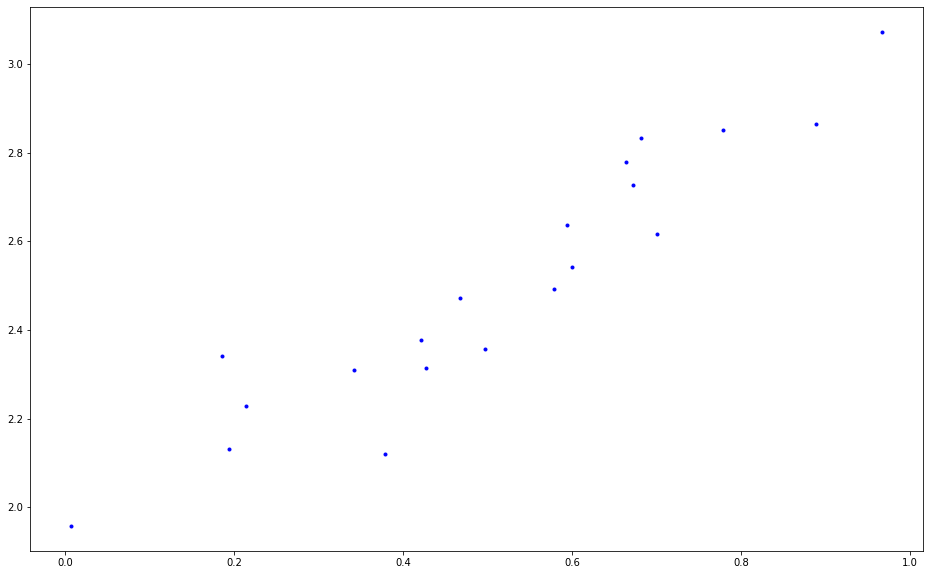

In [31]:
plt.plot(X_train, y_train, 'b.')
plt.show()

#### Define a linear regression model

In [42]:
# Build a custom layer for the linear regression model
class LinearLayer(Layer):
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1, ), initializer='random_normal')
        self.b = self.add_weight(shape=(1, ), initializer='zeros')
        
    def call(self, inputs):
        return self.m * inputs + self.b
    
linear_regression = LinearLayer()

In [43]:
linear_regression(X_train)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-0.00999793, -0.02673336, -0.01040294, -0.036666  , -0.0357274 ,
       -0.03764858, -0.02298309, -0.00036403, -0.03614097, -0.04187095,
       -0.05201402, -0.01837858, -0.03109264, -0.02035277, -0.01153002,
       -0.03224227, -0.02266003, -0.03195651, -0.0477748 , -0.02514589],
      dtype=float32)>

In [44]:
linear_regression.weights

[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.05376218], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

#### Define the loss function

In [45]:
def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

starting_loss = SquaredError(linear_regression(X_train), y_train)
print('Starting loss', starting_loss.numpy())

Starting loss 6.4852614


#### Train and plot the model

In [46]:
learning_rate = 0.05
steps = 25

for i in range(steps):
    with tf.GradientTape() as tape:
        predictions = linear_regression(X_train)
        loss = SquaredError(predictions, y_train)
        
    gradients = tape.gradient(loss, linear_regression.trainable_variables)
    
    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])
    
    print('Step {}, Loss {:.4f}'.format(i, loss.numpy()))

Step 0, Loss 6.4853
Step 1, Loss 4.9384
Step 2, Loss 3.7610
Step 3, Loss 2.8649
Step 4, Loss 2.1829
Step 5, Loss 1.6639
Step 6, Loss 1.2688
Step 7, Loss 0.9681
Step 8, Loss 0.7392
Step 9, Loss 0.5650
Step 10, Loss 0.4325
Step 11, Loss 0.3316
Step 12, Loss 0.2548
Step 13, Loss 0.1963
Step 14, Loss 0.1518
Step 15, Loss 0.1180
Step 16, Loss 0.0922
Step 17, Loss 0.0726
Step 18, Loss 0.0576
Step 19, Loss 0.0463
Step 20, Loss 0.0376
Step 21, Loss 0.0310
Step 22, Loss 0.0260
Step 23, Loss 0.0222
Step 24, Loss 0.0193


In [48]:
print('m: {}, trained m: {}'.format(1, linear_regression.m.numpy()))
print('b: {}, trained b: {}'.format(2, linear_regression.b.numpy()))

m: 1, trained m: [0.9889205]
b: 2, trained b: [1.9128261]


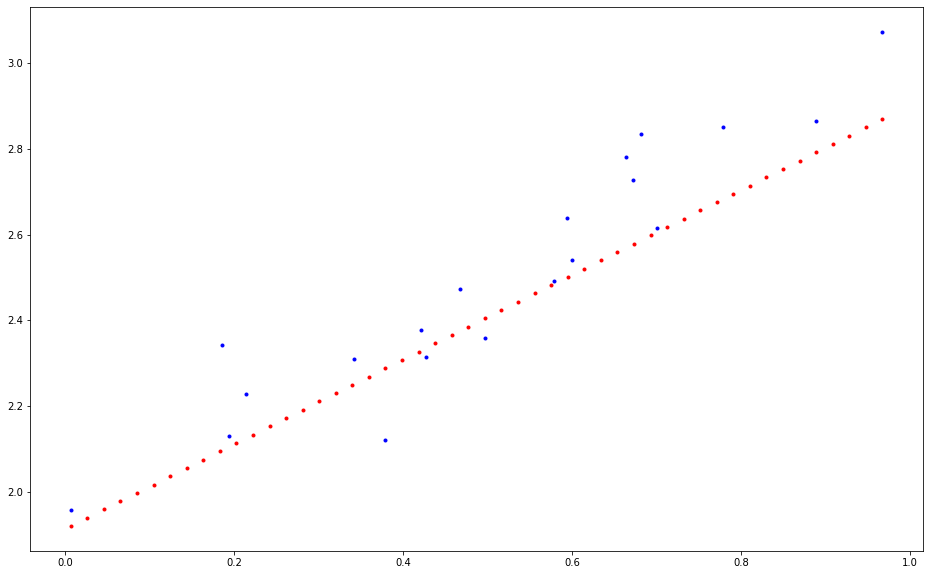

In [49]:
plt.plot(X_train, y_train, 'b.')
X_linear_regression = np.linspace(min(X_train), max(X_train), 50)
plt.plot(X_linear_regression, linear_regression.m * X_linear_regression + linear_regression.b, 'r.')
plt.show()